# Setup


In [11]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, timedelta
from collections import ChainMap
from functools import partial
from json import loads
from tensorflow.keras.losses import MAPE

palette = partial(sns.color_palette, "colorblind")
sns.set_theme(style='white', font_scale=3)


In [12]:
# Define the pathway for the figure and table outputs.
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', 
    twin=False, commas=False, hide_tick_range=False
):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    if hide_tick_range:
        ticks = sorted(ticks)
    else:
        ticks = sorted([*ticks, *tick_range])
    eval(f"ax.set_{axis}ticks")(ticks)
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(
            f'''f"{{e:{',' if commas else ''}.0{dp}{fmt}}}"'''
        ))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, style_legend=True, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if permitted and a legend is present.
        if ax.get_legend() and style_legend:
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()

def to_model_label(name):
    '''Take a model file name and return the model name'''
    label = 'Multivariate ' if 'multiv' in name else 'Univariate '
    label += 'Deep ' if 'deep' in name else 'Shallow '
    label += 'MLP' if 'MLP' in name else 'BD-LSTM'
    return label

def format_timedelta(td, unit='H'):
    '''Convert timedelta objects to presentable strings.'''
    # Get the regex pattern for the given unit (minute or hour).
    ptn = r'^(?:.*days 0?)?' r'(.*):' if unit=='H' \
        else r'\d+:0?(.*)\.' if unit == 'M' \
        else '$'
    # Return the extracted string if the pattern matches.
    # Otherwise, return and empty string.
    td_mtch = match(ptn, str(td))
    return td_mtch.group(1) if td_mtch else td_mtch

def get_metric_renamer(mt_cols, troubleshoot=False):
    """Take a list of metric columns and return a dictionary mapping \
them to presentable names."""
    tbl_cols = ['1 Hour', '24 Hour', 'Mean']
    rename_dict = dict(zip(mt_cols, tbl_cols))
    if troubleshoot:
        # Print the dictionary if the code is being debugged.
        print(rename_dict)
    return rename_dict

def ci(data: pd.Series, alpha=0.05):
    '''Take a vector and a confidence interval alpha. \
Return the confidence interval for the mean.'''
    return norm.ppf(.975) * data.std(ddof=0) / len(data)**.5

def format_batch_size(e, dollars=False):
    """LaTeX format a batch-size integer as a power of 2."""
    e_fmt = f"2^{{{np.log2(e):.0f}}}"
    if dollars:
        e_fmt = f"${e_fmt}$"
    return e_fmt

def format_weight_decay(e, dollars=False):
    """LaTeX format a weight-decay value as a power of 10."""
    e_fmt = f"10^{{-{f'{e:.09f}'.find('1')-1}}}"
    if dollars:
        e_fmt = f"${e_fmt}$"
    return e_fmt

def move_tex_label(tex):
    '''Move the label of a TEX table from the top to the bottom.'''
    return sub(
        r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', 
        r'\1\3\2\4', tex
    )


# Learning rate experiment summary

In [25]:
# Load the learning rate experiment results.
lr_smry_df = pd.read_csv(
    'Results/lr scheduler comparison on shallow MLP.csv'
)
# Convert to a long dataframe.
lr_smry_df = lr_smry_df\
    .melt(id_vars='function', var_name='Step', value_name='MAPE')
# LaTeX format the function name.
lr_smry_df.function = lr_smry_df.function\
    .apply(lambda e: sub(r'.*(\d)', r'$f_\1$', e))
# Format the step value for presenation.
lr_smry_df.Step = lr_smry_df.Step\
    .apply(lambda e: sub(r'.*?(\d+)', r'\1 hour', e))

lr_smry_df


,function,Step,MAPE
0,$f_1$,1 hour,1.234822
1,$f_1$,1 hour,1.084792
2,$f_1$,1 hour,1.160965
3,$f_1$,1 hour,1.068854
4,$f_1$,1 hour,1.082540
...,...,...,...
75,$f_4$,24 hour,3.811834
76,$f_4$,24 hour,3.856075
77,$f_4$,24 hour,4.101814
78,$f_4$,24 hour,3.876484


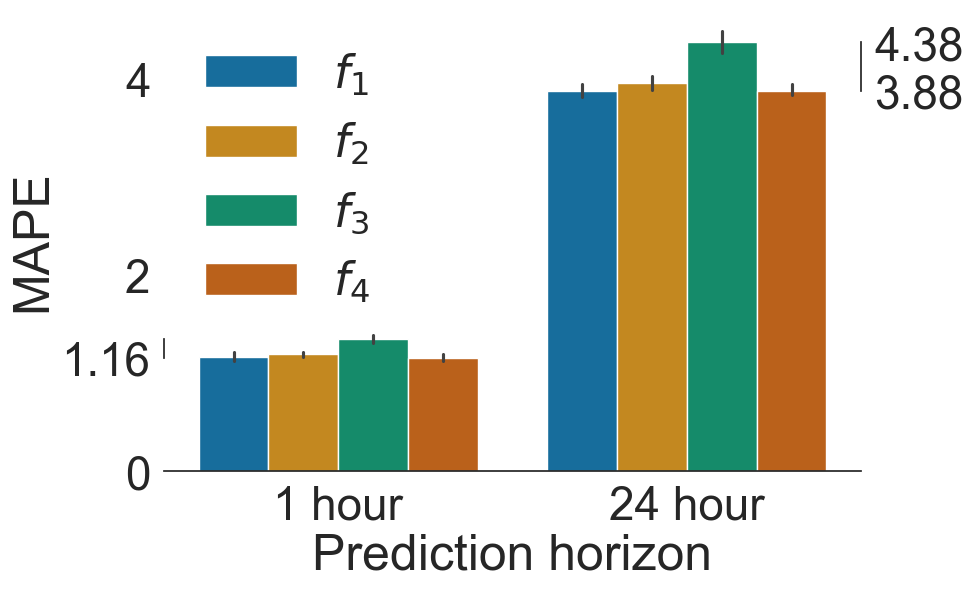

In [26]:
# Visualise the experimental results.
fig, ax = plt.subplots(figsize=(9, 6))

line = sns.barplot(
    data=lr_smry_df, x='Step', y='MAPE', hue='function', 
    palette=palette(lr_smry_df.function.nunique())
)

# Aggregate the 1-hour mean by function type.
h1_means = lr_smry_df[lr_smry_df.Step == '1 hour']\
    .groupby(['function']).MAPE.mean()
# Neaten the plot in line with Tuftian principles.
neaten_ticks(
    ax, 'y', [h1_means.min(), h1_means.max()], [0, h1_means.min(), 2, 4], 
    dp=2, hide_tick_range=True
)

# Duplicate the axis to present ticks on both sides.
ax2 = ax.twinx()
# Aggregate the 24-hour mean by function type.
h24_means = lr_smry_df[lr_smry_df.Step == '24 hour']\
    .groupby(['function']).MAPE.mean()
# Neaten the plot in line with Tuftian principles.
neaten_ticks(
    ax2, 'y', [h24_means.min(), h24_means.max()], [], dp=2, twin=True
)
# Pair the range of the y-axes.
ax2.set_ylim(*ax.get_ylim())

# Hide ticks.
ax.tick_params(axis='both', color='white')
ax2.tick_params(axis='both', color='white')

ax.set_xlabel('Prediction horizon')

# Blend the legend into the plot.
legend = line.legend(loc=2)
legend.get_frame().set_alpha(0)

# Further neaten and save the plot.
show(
    fig, [ax, ax2], delax=False, despine_twin=True, style_legend=False, 
    file='LR scheduling experiment results'
)


In [16]:
# Load the learning rate experiment training histories.
with open('Results/lr scheduler comparison on shallow MLP.json', 'r') as f:
    lr_res = pd.DataFrame(loads(f.read()))

# Create the dataframe to build the JSON into.
lr_res_df = pd.DataFrame()

# For each function in the result data...
for col in lr_res:
    # Calculate the mean and confidence interval of the loss at each epoch.
    loss_mean_data = lr_res[col].apply(pd.Series).loss\
        .apply(pd.Series).agg(['mean', ci]).T
    # Calculate the mean and CI of the validation loss at each epoch.
    val_loss_mean_data = lr_res[col].apply(pd.Series).val_loss\
        .apply(pd.Series).agg(['mean', ci]).T
    # For both mean and CI dataframes...
    for i, mean_data in enumerate([loss_mean_data, val_loss_mean_data]):
        # Calculate the upper and lower CI.
        mean_data['upper'] = mean_data['mean'] + mean_data.ci
        mean_data['lower'] = mean_data['mean'] - mean_data.ci
        mean_data = mean_data.drop(columns=['ci'])
        # List the dataset type, function used, and epoch number.
        mean_data['set'] = 'validation' if i else 'train'
        mean_data['function'] = col
        mean_data['epoch'] = mean_data.index + 1
        # Consolidate into central dataframe.
        lr_res_df = pd.concat([lr_res_df, mean_data]).reset_index(drop=True)

# LaTex format the function name. 
lr_res_df.function = lr_res_df.function\
    .apply(lambda e: sub(r'.*(\d)', r'$f_\1$', e))

lr_res_df


,mean,upper,lower,set,function,epoch
0,99.903358,99.919843,99.886872,train,$f_1$,1
1,99.568192,99.635720,99.500663,train,$f_1$,2
2,98.016785,98.286571,97.746999,train,$f_1$,3
3,94.006918,94.743375,93.270462,train,$f_1$,4
4,86.196698,87.666146,84.727250,train,$f_1$,5
...,...,...,...,...,...,...
15995,2.508362,2.545373,2.471352,validation,$f_4$,1996
15996,2.508346,2.545364,2.471328,validation,$f_4$,1997
15997,2.508301,2.545298,2.471304,validation,$f_4$,1998
15998,2.508275,2.545282,2.471268,validation,$f_4$,1999


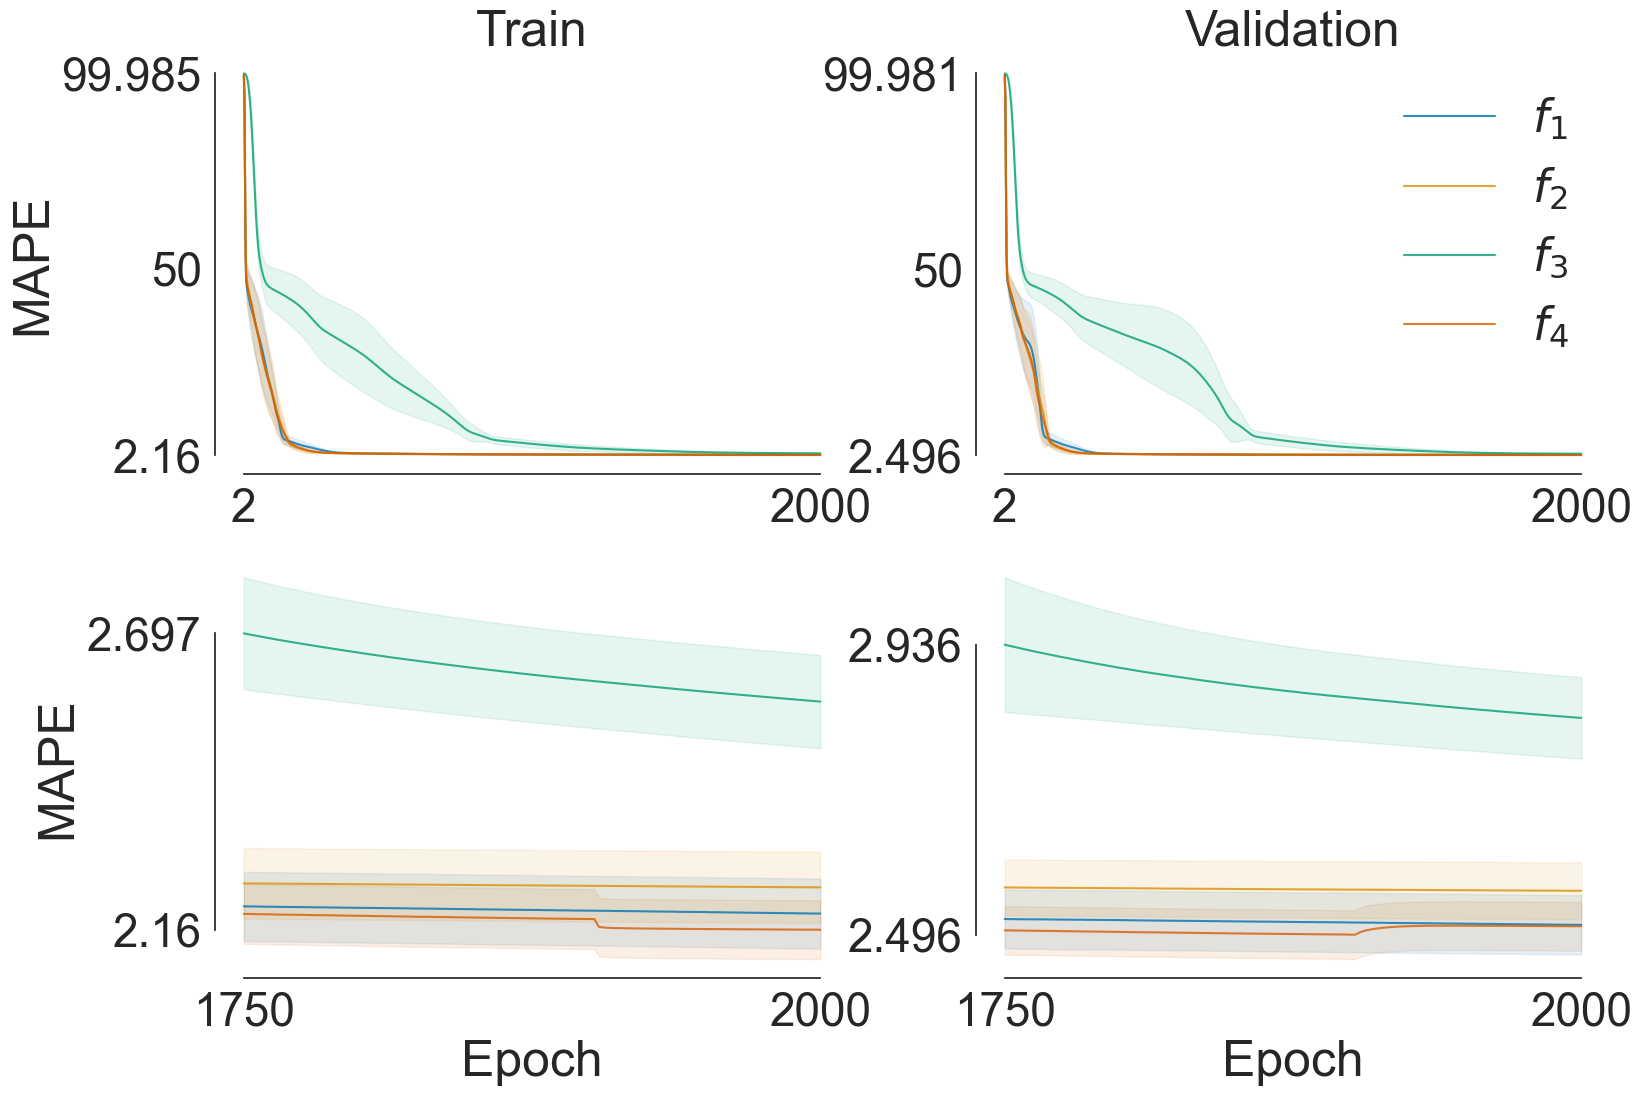

In [18]:
# Create a visualisation figure with 2x2 subplots. 
cols = lr_res_df.set.unique()
n_col, n_row = len(cols), 2
fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 6*n_row))
axes = axes.flatten()
fill = palette(lr_res_df.function.nunique())

# For each plot index generate a visualisation of the training histories.
for i in range(n_col*n_row):
    ax, col = axes[i], cols[i % 2]

    data=lr_res_df[(
        (lr_res_df.set == col)
        & (lr_res_df.index % 2 == 1) # Use only even epochs.
     )]
    # If in the final row...
    if i >= 2:
        yticks = []
        # Zoom in on the last 250 epochs.
        data = data[data.epoch >= 1750]
        # Prepare to remove the column titles and y label add the x label.
        title, xlabel, ylabel = '', 'Epoch', ''
    # If in the first row...
    else:
        yticks = [50]
        # Prepare to add the column titles remove the axis labels.
        title, xlabel, ylabel = col.title(), '', ''
    # If in the first column, list MAPE in the y axis.
    if i % 2 == 0:
        ylabel = 'MAPE'

    # Generate subplot and set labels.
    line = sns.lineplot(
        ax=ax, data=data, x='epoch', y='mean', hue='function', 
        palette=fill, alpha=0.8
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # For each enumerated function name...
    for j, fnct in enumerate(data.function.unique()):
        # Shade in the confidence interval for the function's line.
        data_f = data[data.function == fnct] # Data for function.
        ax.fill_between(
            data_f.epoch, 
            data_f.upper, 
            data_f.lower, 
            alpha=0.1,
            color=fill[j]
        )

    # Remove y-ticks and neaten the plot in line with Tuftian principles.
    ax.set_yticks([])
    neaten_ticks(
        ax, 'y', [data['mean'].min(), data['mean'].max()], 
        yticks, dp=3
    )
    neaten_ticks(ax, 'x', [data.epoch.min(), data.epoch.max()], [])

    # Remove all legends not in the top-right of the figure.
    if i != 1:
        ax.get_legend().remove()
    else:
        legend = line.legend()
        legend.get_frame().set_alpha(0)

    # Hide ticks.
    ax.tick_params(axis='both', color='white')

# Further neaten and save the plot.
show(
    fig, axes, style_legend=False, 
    file='LR scheduling experiment training histories'
)


# Hyperparameter grid search

In [31]:
param_grid = { # Parameter grid used in the grid search experiments.
    'batch_size': [2**8, 2**9, 2**10],
    'optimizer__weight_decay': [1e-3, 1e-4, 1e-5],
    'optimizer__beta_1': [.8, .9, .95],
}

param_grid = pd.DataFrame(param_grid)

# Format the variables for presentation.
param_grid.batch_size = param_grid.batch_size.apply(format_batch_size)
param_grid.optimizer__weight_decay = param_grid\
    .optimizer__weight_decay.apply(format_weight_decay)
param_grid.columns = [
    sub('_+', ' ', e).title().replace('Beta 1', '$\\beta_1$') 
    for e in param_grid
]

# Style and format the grid. Convert it to LaTeX.
pgrid_tex = move_tex_label(
    param_grid.apply(
        lambda d: f"$\\left[{', '.join([str(e) for e in d])}\\right]$"
    ).to_frame().reset_index()\
        .rename(columns={'index': 'Hyperparameter', 0: 'Values Searched'})\
        .style.hide()\
        .to_latex(
            label='param-grid', position_float="centering", hrules=True, 
            position='H', column_format='lr', 
            caption = f"The hyperparameter matrix used in the grid search. \
The optimiser values were passed to the Adam optimiser, \
and the batch size was passed to the models' fit methods."
    ))

print(pgrid_tex)

with open(f"{tbl_dir}parameter grid.tex", 'w') as f:
    f.write(pgrid_tex)


\begin{table}[H]
\centering
\begin{tabular}{lr}
\toprule
Hyperparameter & Values Searched \\
\midrule
Batch Size & $\left[2^{8}, 2^{9}, 2^{10}\right]$ \\
Optimizer Weight Decay & $\left[10^{-3}, 10^{-4}, 10^{-5}\right]$ \\
Optimizer $\beta_1$ & $\left[0.8, 0.9, 0.95\right]$ \\
\bottomrule
\end{tabular}
\caption{The hyperparameter matrix used in the grid search. The optimiser values were passed to the Adam optimiser, and the batch size was passed to the models' fit methods.}
\label{param-grid}
\end{table}



In [30]:
# List for grid search results.
gsearch = []

# For each model...
for mdl in ['MLP', 'BD-LSTM']:
    with open(f'Results/{mdl} gridsearch results.json', 'r') as f: 
        # Add results to the list.
        gsearch.append({
            'model': mdl, **ChainMap(*loads(f.read()).values())
        })

# Convert the list to a dataframe and format the values.
gsearch_res = pd.DataFrame(gsearch)
gsearch_res.batch_size = gsearch_res.batch_size\
    .apply(format_batch_size, dollars=True)
gsearch_res.weight_decay = gsearch_res.weight_decay\
    .apply(format_weight_decay, dollars=True)

# Copy the param_grid columns.
gsearch_res.columns = ['Model', *param_grid.columns]

# Generate the TEX string and save the TEX file.
gsearch_tex = move_tex_label(gsearch_res.style.hide()\
    .format("{:.02f}", subset=gsearch_res.columns[-1])\
    .to_latex(
        label='gsearch-res', position_float="centering", hrules=True, 
        position='H', column_format='lrrr', 
        caption = f"The optimal hyperparameters for each model found in \
the grid search. The optimiser values were passed to the Adam optimiser, \
and the batch size was passed to the models' fit methods."
    ))

print(gsearch_tex)

with open(f"{tbl_dir}grid search results.tex", 'w') as f:
    f.write(gsearch_tex)


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model & Batch Size & Optimizer Weight Decay & Optimizer $\beta_1$ \\
\midrule
MLP & $2^{8}$ & $10^{-5}$ & 0.95 \\
BD-LSTM & $2^{8}$ & $10^{-5}$ & 0.80 \\
\bottomrule
\end{tabular}
\caption{The optimal hyperparameters for each model found in the grid search. The optimiser values were passed to the Adam optimiser, and the batch size was passed to the models' fit methods.}
\label{gsearch-res}
\end{table}



# Feature reduction results

In [36]:
# Load the feature reduction experiment results.
with open('Results/MLP feature reduction results.json') as f:
    fr_res = loads(f.read())

print(fr_res['description']) # Print experiment details.
del fr_res['description']

# Load the results into a dataframe.
fr_res = pd.DataFrame(fr_res).reset_index()\
    .rename(columns={'index': 'model'})

# Calculate the count of variables and train_times.
fr_res['n_variables'] = fr_res.variables.apply(len)
fr_res['train_time'] = (fr_res[[
    'train_time (us/step)', 'steps', 'epochs'
]].product(axis=1) / 60e6)\
    .apply(lambda e: format_timedelta(timedelta(minutes=e), unit='M'))

# LaTeX format the model label.
fr_res.model = fr_res.model.str\
    .replace(r'1e(-\d)', r'10^{\1}', regex=True).apply(
        lambda e: f"${e}$"\
            .replace('e', r'\epsilon')\
            .replace('L1', r'\lambda_{L1}')
    )

# Limit variables and rename remaining columns.
fr_res = fr_res[[
    'model', 'train_time', 'n_variables', 'MAPE_validation'
]]
fr_res.columns = [
    'Model', 'Training Minutes', 'Count of Variables', 'Validation MAPE'
]

# Generate the TEX string and save the TEX file.
fr_tex = move_tex_label(fr_res.style.hide()\
    .format('{:.02f}', subset=['Validation MAPE'])\
    .to_latex(
        label='feat-red', position_float="centering", hrules=True, 
        position='H', column_format='lrrr', caption = f"\
The feature reduction results of the four models reviewed. \
The $\\lambda_{{L1}}$ values represent the weight of the L1 regularisation, \
with $\\lambda_{{L1}}=0$ indicating no regularisation. The $\\epsilon$ \
values represent the minimum sum of coefficients for a variable to be \
included in the model."
    ))

print(fr_tex)

with open(f"{tbl_dir}feature reduction.tex", 'w') as f:
    f.write(fr_tex)


Tested prospects for reducing features through L1 regularisation of the kernel weights. Epsilon (e) is an arbitrary exclusion value. If the sum of the kernel weights for a variable are below or equal to e, the variable is dropped.
\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model & Training Minutes & Count of Variables & Validation MAPE \\
\midrule
$\lambda_{L1}=0.1$ & 5:09 & 66 & 4.68 \\
$\lambda_{L1}=0.0$ & 5:09 & 66 & 2.58 \\
$\epsilon>10^{-3}$ & 4:54 & 51 & 2.80 \\
$\epsilon>10^{-2}$ & 4:43 & 19 & 3.01 \\
\bottomrule
\end{tabular}
\caption{The feature reduction results of the four models reviewed. The $\lambda_{L1}$ values represent the weight of the L1 regularisation, with $\lambda_{L1}=0$ indicating no regularisation. The $\epsilon$ values represent the minimum sum of coefficients for a variable to be included in the model.}
\label{feat-red}
\end{table}



# Training times


In [32]:
# Load the training times metadata.
ttimes = pd.read_csv('models/train_times.csv', parse_dates=['start_time'])
ttimes.train_time = ttimes.train_time.astype('timedelta64[ns]')
ttimes['total_minutes'] = ttimes.train_time.dt.total_seconds() / 60
ttimes['total_hours'] = ttimes.total_minutes / 60
ttimes['label'] = ttimes.model.apply(to_model_label)

ttimes


,model,start_time,train_time,epochs,steps,total_minutes,total_hours,label
0,Final_MLP_shallow_multiv,2024-04-11 23:28:57.676672,0 days 02:01:59.548757,10000,2456,121.992479,2.033208,Multivariate Shallow MLP
1,Final_MLP_deep_multiv,2024-04-12 01:30:58.811206,0 days 01:48:00.476131,4000,2456,108.007936,1.800132,Multivariate Deep MLP
2,Final_LSTM_shallow_multiv,2024-04-12 03:19:00.561206,0 days 02:08:37.538500,73,2456,128.625642,2.143761,Multivariate Shallow BD-LSTM
3,Final_LSTM_deep_multiv,2024-04-12 05:27:52.354039,0 days 01:59:34.425274,21,2456,119.573755,1.992896,Multivariate Deep BD-LSTM
4,Final_MLP_shallow_univ,2024-04-12 07:28:18.614487,0 days 01:57:50.300272,10500,2456,117.838338,1.963972,Univariate Shallow MLP
5,Final_MLP_deep_univ,2024-04-12 09:58:48.883013,0 days 01:44:32.686466,3950,2456,104.544774,1.742413,Univariate Deep MLP
6,Final_LSTM_shallow_univ,2024-04-12 11:43:22.791439,0 days 02:11:04.185515,105,2456,131.069759,2.184496,Univariate Shallow BD-LSTM
7,Final_LSTM_deep_univ,2024-04-12 13:54:37.849943,0 days 02:12:59.734693,30,2456,132.995578,2.216593,Univariate Deep BD-LSTM
8,Extended_Final_LSTM_deep_univ,2024-04-13 09:07:24.221449,0 days 04:54:25.200049,120,2456,294.420001,4.907000,Univariate Deep BD-LSTM
9,Extended_Final_LSTM_shallow_multiv,2024-04-13 13:11:03.177207,0 days 02:36:53.683472,146,2456,156.894725,2.614912,Multivariate Shallow BD-LSTM


In [33]:
# Filter out the extra training data.
first_ttimes = ttimes[ttimes.model.str.match('^Final')]\
    .sort_values('epochs')

first_ttimes


,model,start_time,train_time,epochs,steps,total_minutes,total_hours,label
3,Final_LSTM_deep_multiv,2024-04-12 05:27:52.354039,0 days 01:59:34.425274,21,2456,119.573755,1.992896,Multivariate Deep BD-LSTM
7,Final_LSTM_deep_univ,2024-04-12 13:54:37.849943,0 days 02:12:59.734693,30,2456,132.995578,2.216593,Univariate Deep BD-LSTM
2,Final_LSTM_shallow_multiv,2024-04-12 03:19:00.561206,0 days 02:08:37.538500,73,2456,128.625642,2.143761,Multivariate Shallow BD-LSTM
6,Final_LSTM_shallow_univ,2024-04-12 11:43:22.791439,0 days 02:11:04.185515,105,2456,131.069759,2.184496,Univariate Shallow BD-LSTM
5,Final_MLP_deep_univ,2024-04-12 09:58:48.883013,0 days 01:44:32.686466,3950,2456,104.544774,1.742413,Univariate Deep MLP
1,Final_MLP_deep_multiv,2024-04-12 01:30:58.811206,0 days 01:48:00.476131,4000,2456,108.007936,1.800132,Multivariate Deep MLP
0,Final_MLP_shallow_multiv,2024-04-11 23:28:57.676672,0 days 02:01:59.548757,10000,2456,121.992479,2.033208,Multivariate Shallow MLP
4,Final_MLP_shallow_univ,2024-04-12 07:28:18.614487,0 days 01:57:50.300272,10500,2456,117.838338,1.963972,Univariate Shallow MLP


In [40]:
# Select variables and create their labels.
cols = ['label', 'epochs', 'total_hours']
labels = [e.replace('_', ' ').title() for e in cols]

# Generate the TEX string and save the TEX file.
ttime_tex = move_tex_label(first_ttimes[cols].assign(
    total_hours = first_ttimes.total_hours\
        .apply(lambda td: format_timedelta(timedelta(hours=td)))
).rename(columns={
    **dict(zip(cols, labels)), 'total_hours': 'Training Hours'
}).style.hide()\
    .format('{:,}', subset=['Epochs'])\
    .to_latex(
        label='ttimes', position_float="centering", hrules=True, 
        position='H', column_format='lrr', caption = f"The number of \
training epochs completed within approximately two hours. MLPs can \
undergo magnitudes more training than BD-LSTMs within the same time frame. \
We hypothesise that this had a significant impact on the test results."
    ))

print(ttime_tex)

with open(f"{tbl_dir}train times.tex", 'w') as f:
    f.write(ttime_tex)


\begin{table}[H]
\centering
\begin{tabular}{lrr}
\toprule
Label & Epochs & Training Hours \\
\midrule
Multivariate Deep BD-LSTM & 21 & 1:59 \\
Univariate Deep BD-LSTM & 30 & 2:12 \\
Multivariate Shallow BD-LSTM & 73 & 2:08 \\
Univariate Shallow BD-LSTM & 105 & 2:11 \\
Univariate Deep MLP & 3,950 & 1:44 \\
Multivariate Deep MLP & 4,000 & 1:48 \\
Multivariate Shallow MLP & 10,000 & 2:01 \\
Univariate Shallow MLP & 10,500 & 1:57 \\
\bottomrule
\end{tabular}
\caption{The number of training epochs completed within approximately two hours. MLPs can undergo magnitudes more training than BD-LSTMs within the same time frame. We hypothesise that this had a significant impact on the test results.}
\label{ttimes}
\end{table}



In [34]:
# Summaring the full training time data into 
# total training time and epochs per model.
ttime_smry = ttimes[['label', 'epochs', 'train_time']]\
    .groupby('label', as_index=False).sum()
# Format the time values.
ttime_smry.train_time = ttime_smry.train_time.apply(format_timedelta)

# Generate the TEX string and save the TEX file.
ttime_smry_tex = move_tex_label(ttime_smry.sort_values(
        'label', key=lambda d: d.apply(lambda e: first_ttimes.label.to_list().index(e))
).rename(columns={
    'label': 'Model', 'epochs': 'Epochs', 'train_time': 'Total Training Hours'
}).style.hide().to_latex(
    label='tsummary', position_float="centering", hrules=True, position='H', column_format='lrr',
    caption = f"The number of epochs completed and hours of training performed for each model. Models completing significantly more than two hours of training were run on a better suited machine to accelerate the process."
))

print(ttime_smry_tex)

with open(f"{tbl_dir}training summary.tex", 'w') as f:
    f.write(ttime_smry_tex)


\begin{table}[H]
\centering
\begin{tabular}{lrr}
\toprule
Model & Epochs & Total Training Hours \\
\midrule
Multivariate Deep BD-LSTM & 189 & 9:53 \\
Univariate Deep BD-LSTM & 150 & 7:07 \\
Multivariate Shallow BD-LSTM & 511 & 9:57 \\
Univariate Shallow BD-LSTM & 315 & 4:38 \\
Univariate Deep MLP & 3950 & 1:44 \\
Multivariate Deep MLP & 4000 & 1:48 \\
Multivariate Shallow MLP & 10000 & 2:01 \\
Univariate Shallow MLP & 10500 & 1:57 \\
\bottomrule
\end{tabular}
\caption{The number of epochs completed and hours of training performed for each model. Models completing significantly more than two hours of training were run on a better suited machine to accelerate the process.}
\label{tsummary}
\end{table}



# Training histories

In [35]:
# Load the training histories of the final models.
train_hists = glob('models/*history.csv')

# Load the model names and generate the history dictionary.
models = set([match('.*Final_(.*?) ', e).group(1) for e in train_hists])
label_hists = dict()

# For each model...
for m in models:
    # Collect the training history and sort chronologically.
    hists = sorted(
        [hist for hist in train_hists if m in hist], 
        key=lambda e: e.count('Extended')
    )
    # Prepare the compile the history.
    full_hist = pd.DataFrame()
    epoch = 0
    # For history in collection...
    for hist in hists:
        # Conver the index to epoch labels.
        partial_hist = pd.read_csv(hist).reset_index()\
            .rename(columns={'index': 'epoch'})
        partial_hist.epoch += 1 + epoch
        # Updating the max epoch with the new max and append new data.
        epoch = partial_hist.epoch.max()
        full_hist = pd.concat([full_hist, partial_hist])\
            .reset_index(drop=True)
    # Add the compiled history to the dictionary.
    label_hists[to_model_label(m)] = full_hist

# Show whether compiled history matches training metadata.
ttimes.groupby('label').epochs.sum().sort_index() == pd.Series({
    k: v.epoch.max() for k, v 
    in sorted(label_hists.items(), key=lambda e: e[1].epoch.max())
}).sort_index()


label
Multivariate Deep BD-LSTM       True
Multivariate Deep MLP           True
Multivariate Shallow BD-LSTM    True
Multivariate Shallow MLP        True
Univariate Deep BD-LSTM         True
Univariate Deep MLP             True
Univariate Shallow BD-LSTM      True
Univariate Shallow MLP          True
dtype: bool

In [43]:
# Load the AEMO forecast data.
fore = pd.read_csv(
    'data/forecastdemand.csv', parse_dates=['DATETIME', 'LASTCHANGED']
)

# Widen the data to make the prediction horizons separate variables.
fore = fore.pivot(
    columns='PERIODID', index=['DATETIME', 'state'], values='FORECASTDEMAND'
).reset_index().rename(
    columns={2: 'h1_FORECASTDEMAND', 48: 'h24_FORECASTDEMAND'}
)

# Load the modelling data.
df = pd.read_csv(
    'data/modelling_data.csv', parse_dates=['DATETIME'], 
    date_format='%Y-%m-%d %H:%M:%S'
)

# Convert one-hot encoded state variables into a string state column. 
states = ['NSW', 'QLD', 'SA', 'VIC']
df['state'] = df[states].idxmax(axis=1)

# Marge the AEMO forecasts with the modelling data.
df = pd.merge(df, fore, how='left', on=['DATETIME', 'state'])\
    [['TOTALDEMAND', 'h1_FORECASTDEMAND', 'h24_FORECASTDEMAND']]\
    .dropna().reset_index(drop=True)

# Calculate the AEMO MAPE.
aspr_MAPE = np.mean([
    float(MAPE(df.TOTALDEMAND, df.h1_FORECASTDEMAND)),
    float(MAPE(df.TOTALDEMAND, df.h24_FORECASTDEMAND))
])

aspr_MAPE


2.0534370802518773

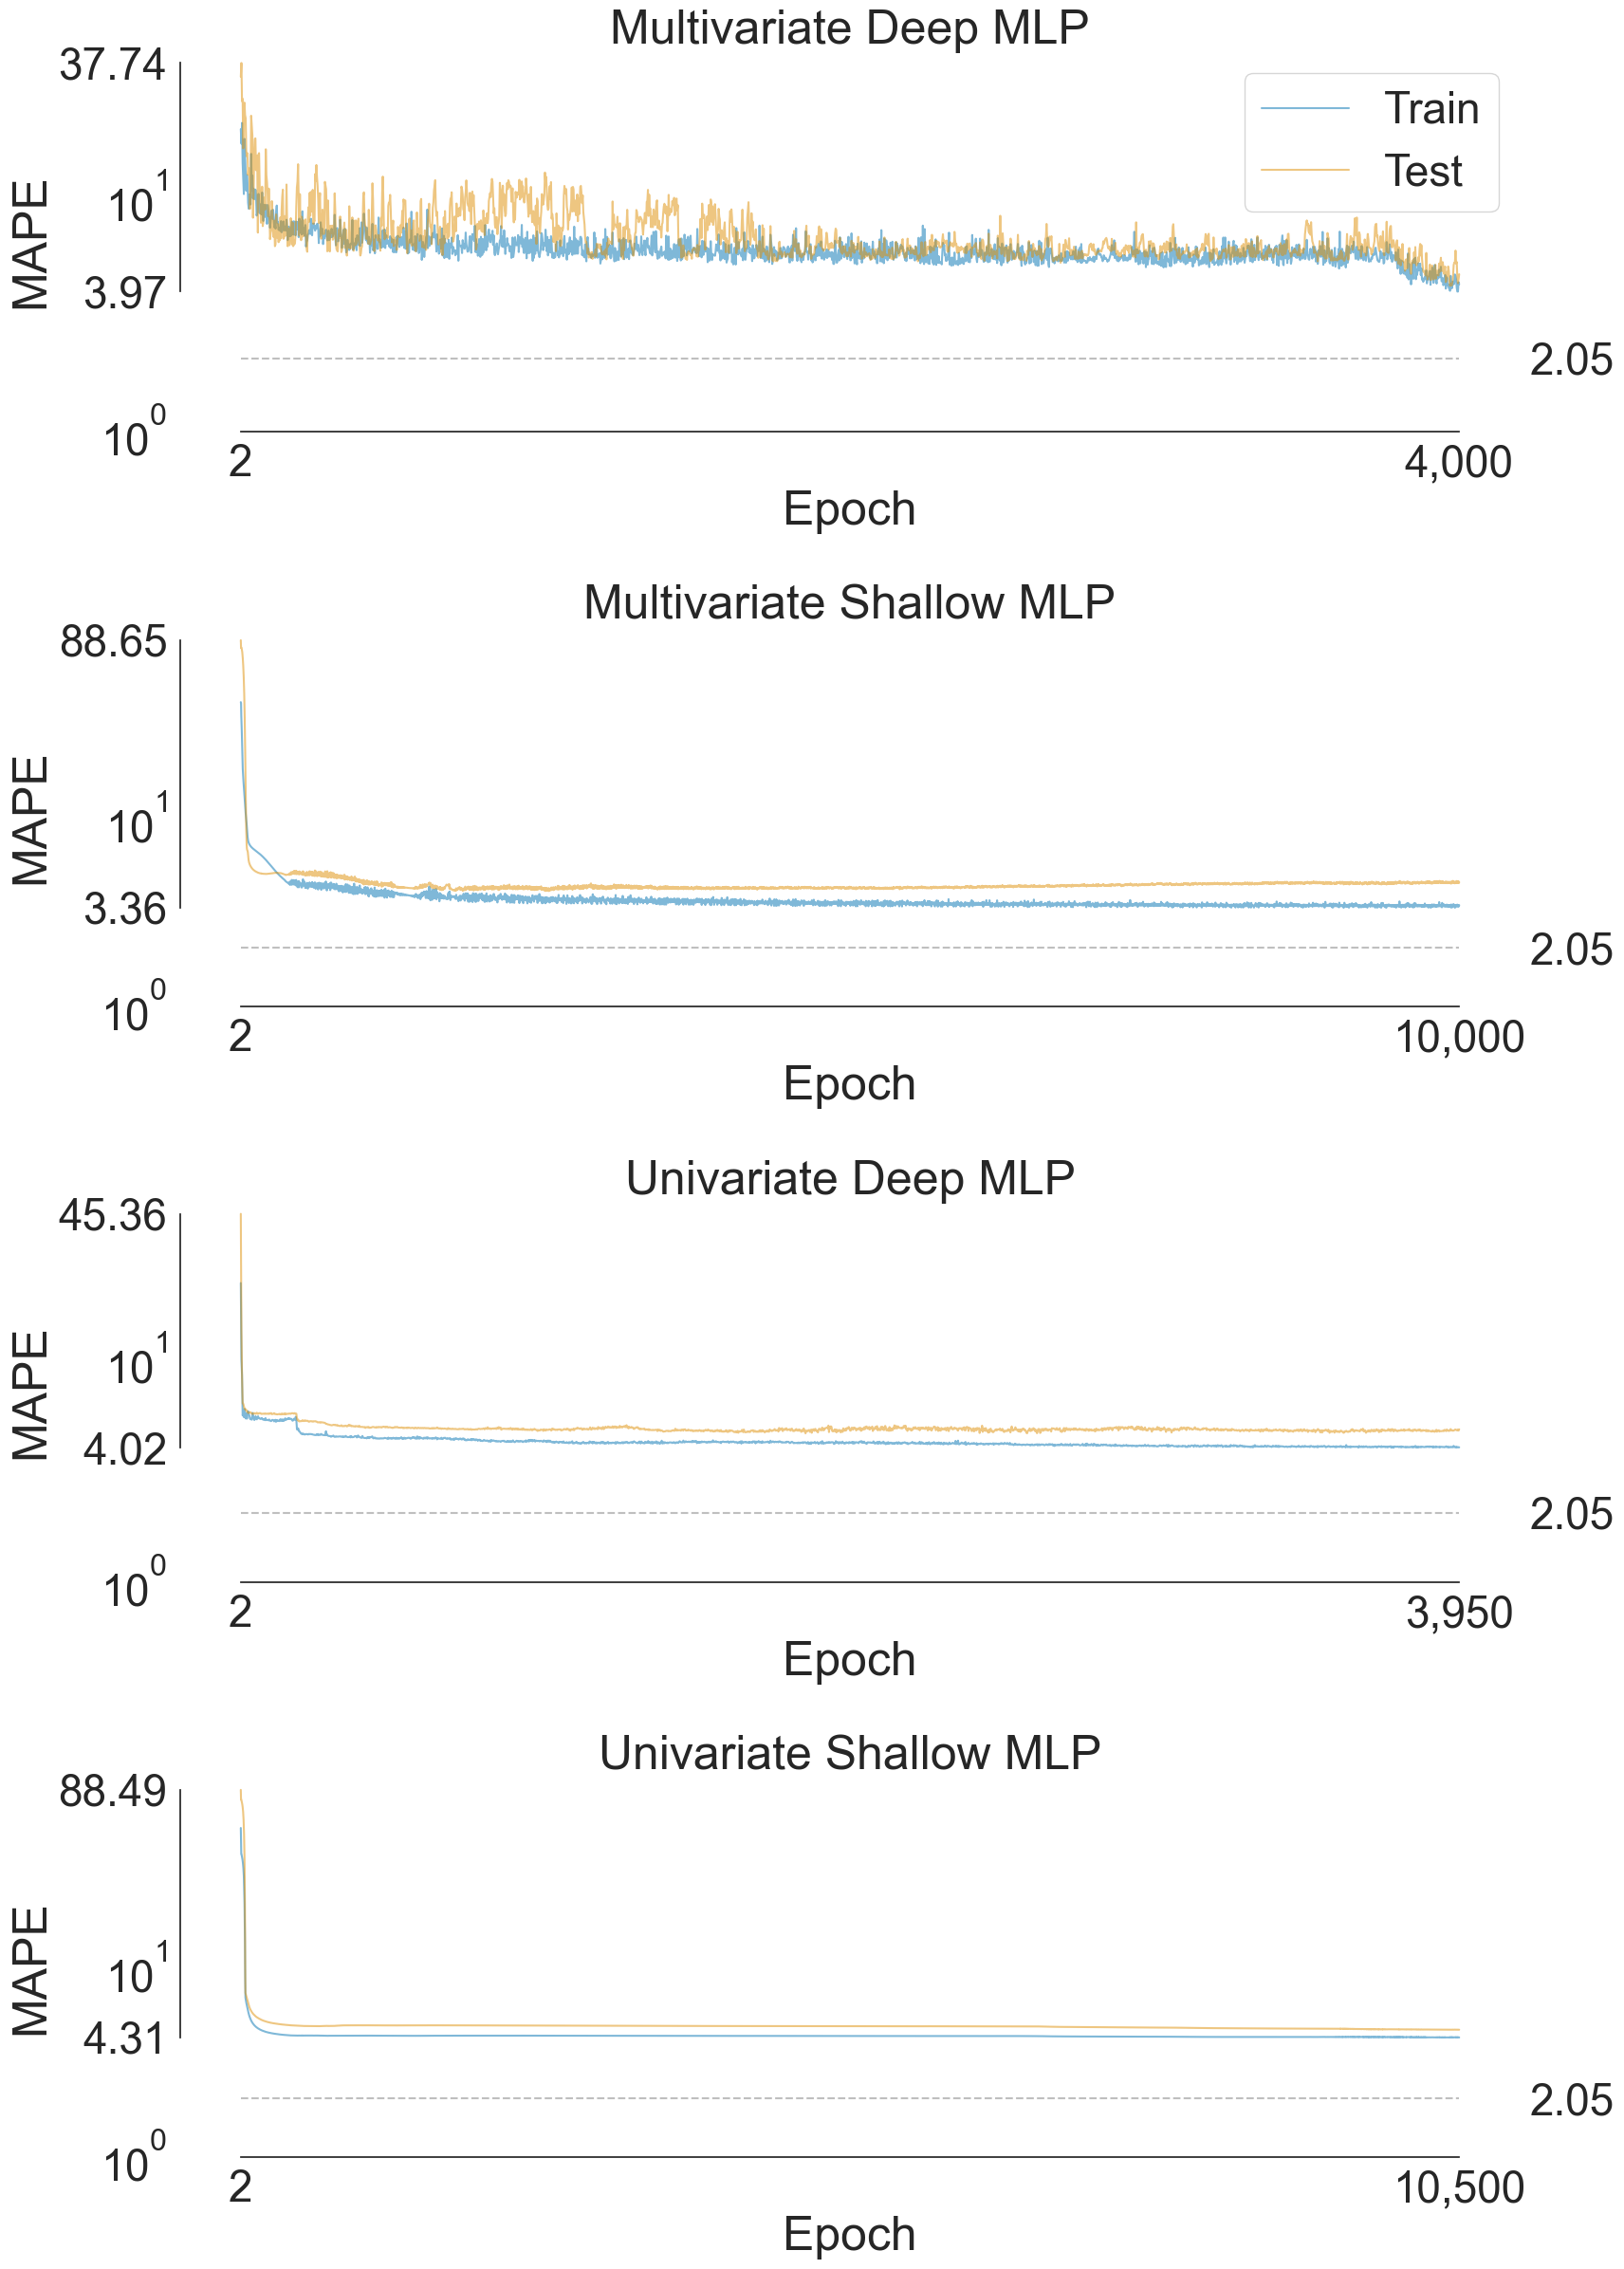

In [44]:
# Separate the training histories for each model group.
mdls = ['MLP', 'BD-LSTM']
mlp_hists, lstm_hists = [
    [(k, v) for k, v in sorted(label_hists.items()) if mdl in k] 
    for mdl in mdls
]

def plot_mhists(m_hists, filename=None):
    '''Take a list of model histories and plot each history on one subplot. \
If a filename is provided, save the figure.'''
    n_rows, n_cols = len(m_hists), 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18*n_cols, 6.2*n_rows))
    colours = palette(2)

    # For each model and its history...
    for i, (m, m_hist) in enumerate(m_hists):
        ax = axes[i]

        # Convert the MSE results to RMSE.
        mse_cols = [e for e in m_hist.columns if 'mean_squared_error' in e]
        m_hist[[
            e.replace('mean_squared_error', 'RMSE') for e in mse_cols
        ]] = m_hist[mse_cols]\
            .apply(lambda d: d.apply(lambda e: e**.5), axis=1)
        
        # Filter out odd epochs.
        m_hist = m_hist.iloc[1::2]

        # Define the metric to be plotted and its label.
        metric, label = 'loss', 'MAPE'

        # Plot the loss and validation loss.
        sns.lineplot(
            m_hist, x='epoch', y=metric, ax=ax, label='Train', 
            alpha=0.5, c=colours[0]
        )
        sns.lineplot(
            m_hist, x='epoch', y=f"val_{metric}", ax=ax, label='Test', 
            alpha=0.5, c=colours[1]
        )
    
        ax.set_yscale('log')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(label)
        ax.set_title(m)

        # Neaten the plot in line with Tuftian principles.
        neaten_ticks(
            ax, 'x', [m_hist.epoch.min(), m_hist.epoch.max()], [], 
            commas=True
        )
        
        ax.set_ylim(1)
        additional_yticks = [1, 10]
        y_min = min(m_hist[f"val_{metric}"].min(), m_hist[metric].min())
        y_max = max(m_hist[f"val_{metric}"].max(), m_hist[metric].max())
        
        # Neaten the plot in line with Tuftian principles.
        neaten_ticks(
            ax, 'y', [y_min, y_max], additional_yticks, 
            dp= 2 if label == 'MAPE' else 0
        )

        # Hide the ticks.
        ax.tick_params(axis='both', color='white')

        # Remove the legend after the first subplot.
        if i > 0:
            ax.get_legend().remove()

        # Show the AEMO MAPE and list its value on the right axis.
        ax.yaxis.set_minor_locator(ticker.FixedLocator([aspr_MAPE]))
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%.2f"))
        ax.tick_params(
            axis='y', which='minor', labelleft=False, labelright=True
        )
        ax.hlines(
            [aspr_MAPE], 2,  max(ax.get_xticks()), 
            color='grey', ls='--', alpha=0.5
        )
        
    # Further neaten and save the plot.
    show(fig, axes.flatten(), True, file=filename, legend_loc=1)

plot_mhists(mlp_hists, f'MLP training histories')


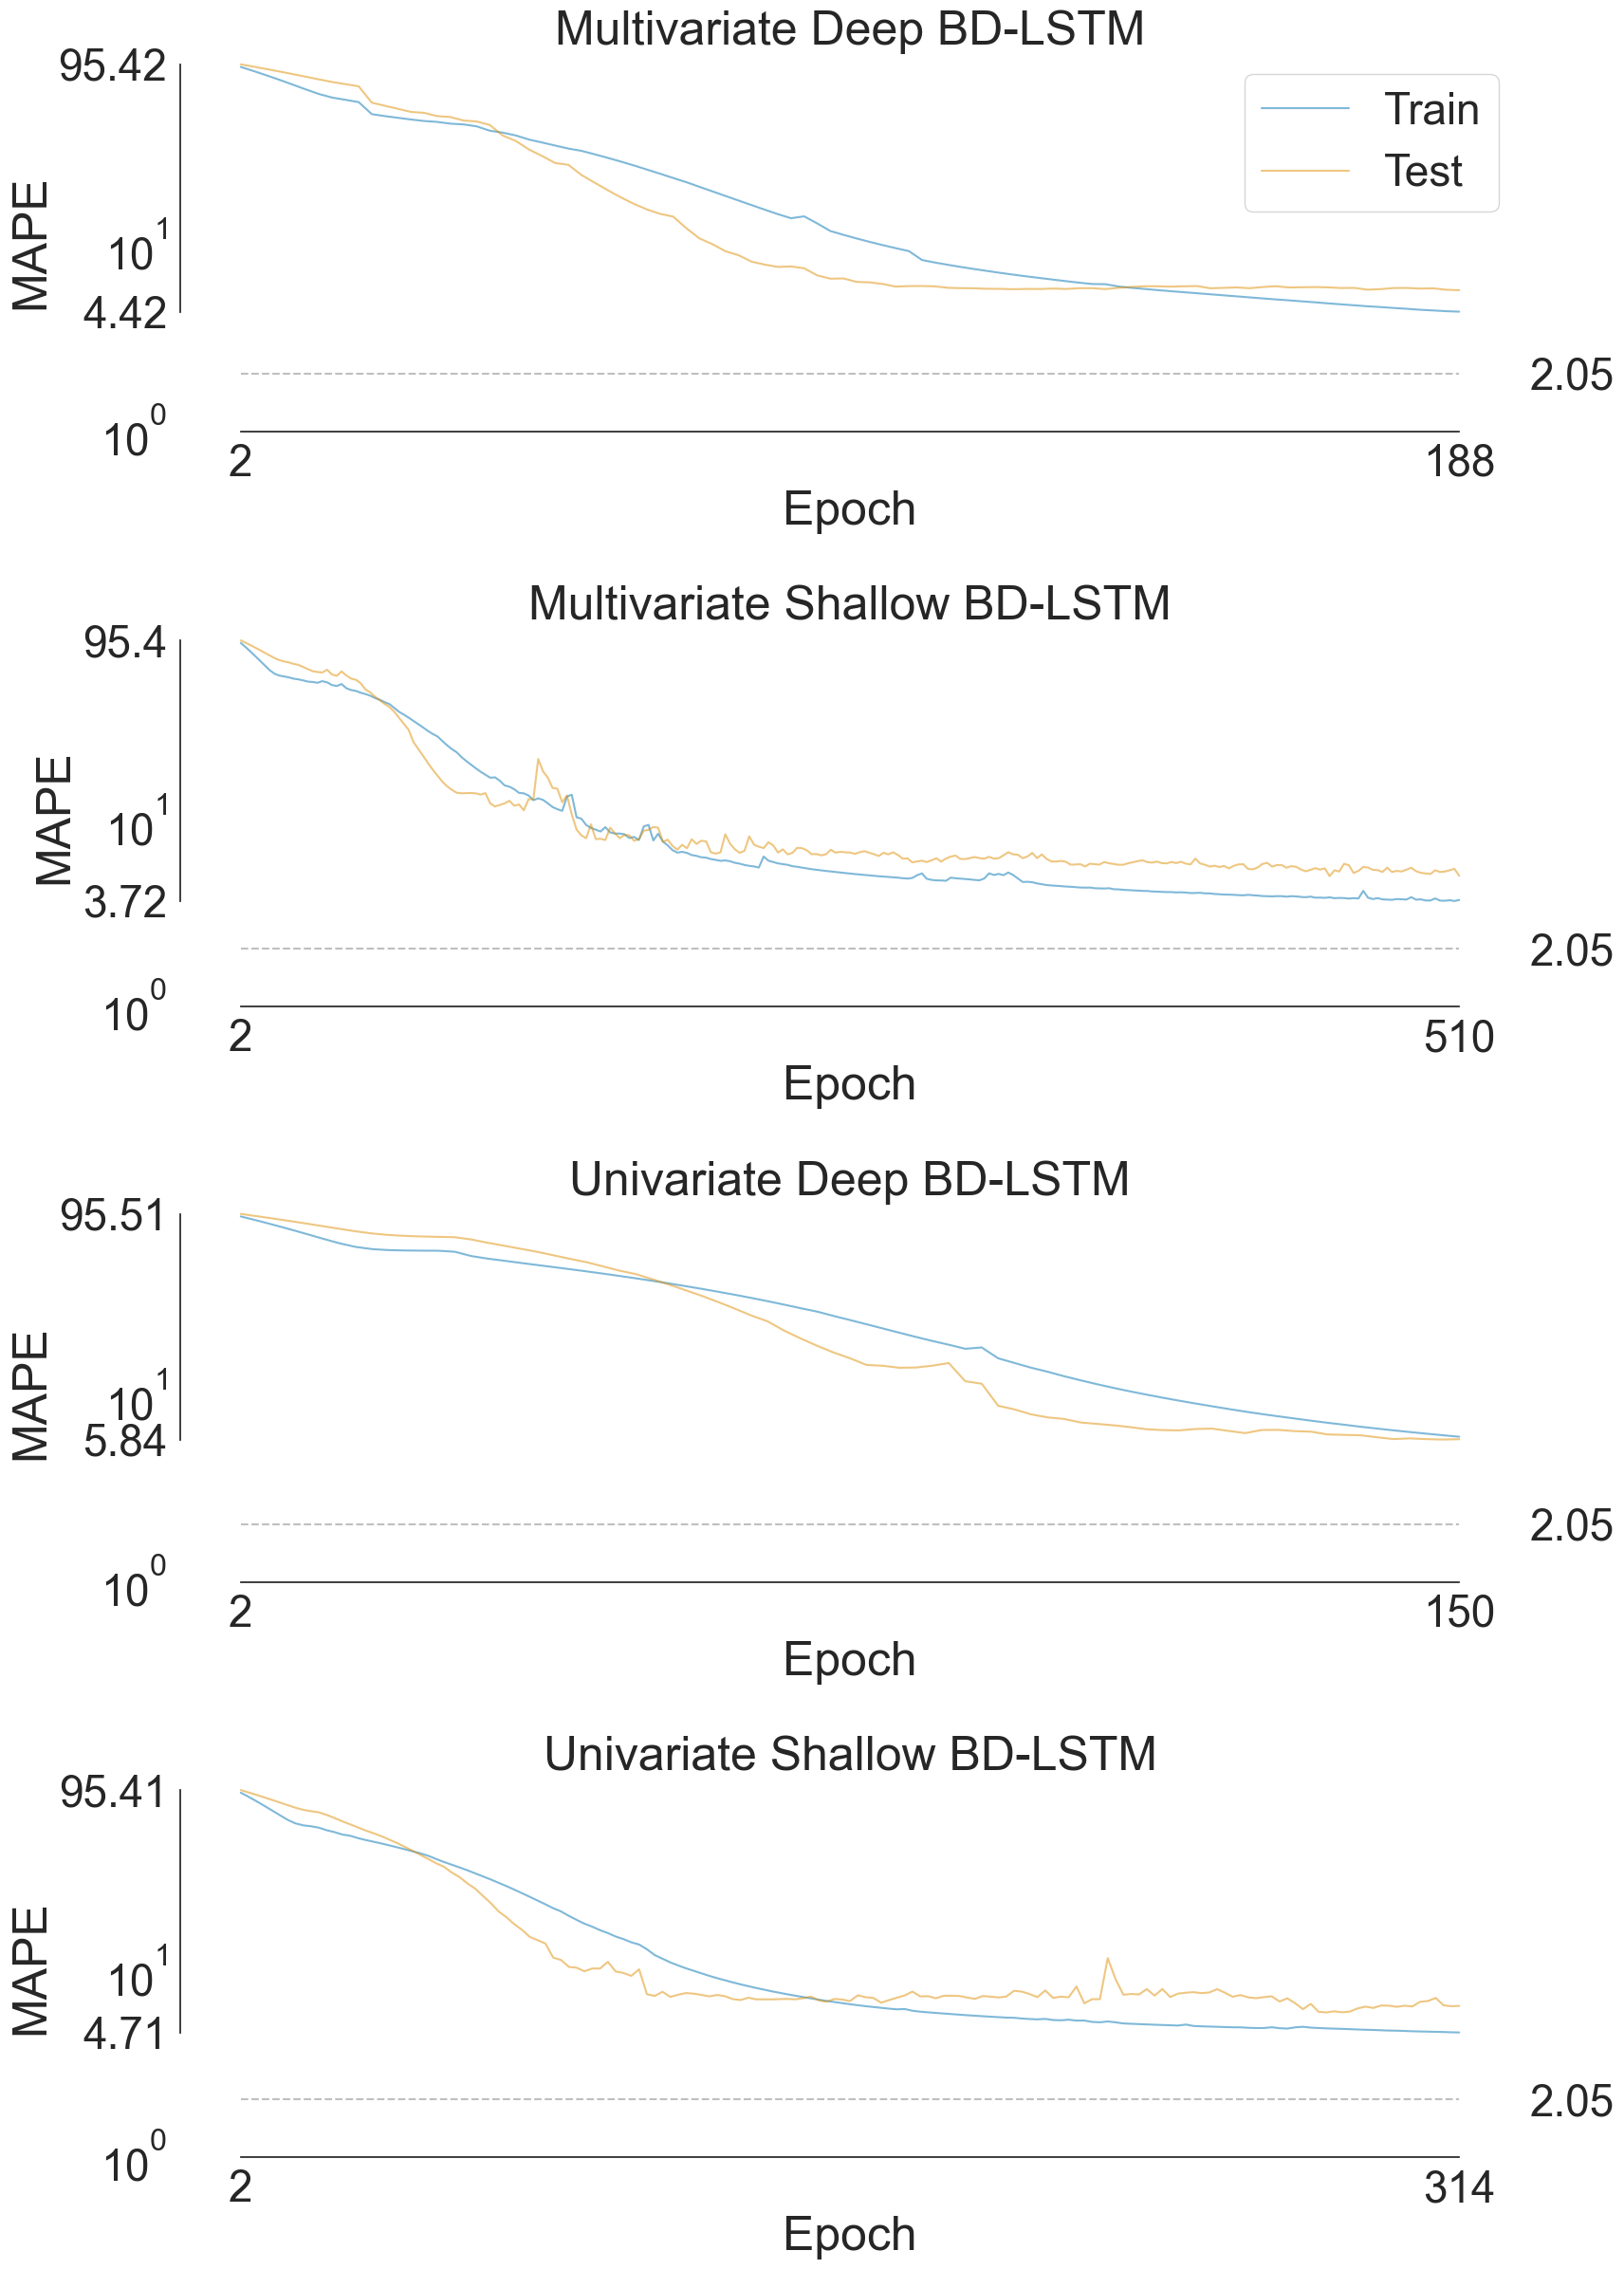

In [45]:
plot_mhists(lstm_hists, f'BD-LSTM training histories')


# Test results


In [41]:
# Load the model test data.
tests = pd.read_csv('Results/model test results.csv')\
    .sort_values('test_MAPE').rename(columns={
        'test_MAPE': 'MAPE_avg', 'test_RMSE': 'RMSE_avg'
    })

# Remove the test_ prefix from columns names and generate labels.
tests.columns = [e.replace('test_', '') for e in tests.columns]
tests.model = tests.model.apply(to_model_label)

# List the prediction horizons and metrics included.
horizons = sorted({e.split('_')[1] for e in tests.columns if '_' in e})
metrics = sorted({e.split('_')[0] for e in tests.columns if '_' in e})

# Define and generate the columns for aggregate results.
groupby_cols = ['Input Type', 'Complexity', 'Model Group']
tests[groupby_cols] = tests.model.str.split(expand=True)

tests


,model,MAPE_avg,RMSE_avg,MAPE_1H,RMSE_1H,MAPE_24H,RMSE_24H,Input Type,Complexity,Model Group
0,Multivariate Shallow MLP,4.592746,344.251339,2.454829,157.533066,6.730966,460.652405,Multivariate,Shallow,MLP
7,Univariate Deep MLP,4.641925,395.710240,1.972130,127.788162,7.312287,544.833740,Univariate,Deep,MLP
4,Multivariate Deep MLP,4.703630,373.064715,2.553428,166.318390,6.853806,500.692932,Multivariate,Deep,MLP
6,Univariate Shallow MLP,4.716120,416.986436,1.776844,119.280052,7.656026,577.518677,Univariate,Shallow,MLP
1,Multivariate Shallow BD-LSTM,5.072569,403.694114,2.682200,189.882523,7.463651,538.406799,Multivariate,Shallow,BD-LSTM
3,Multivariate Deep BD-LSTM,5.683590,431.440049,3.377848,218.846603,7.989808,569.550476,Multivariate,Deep,BD-LSTM
5,Univariate Deep BD-LSTM,5.837089,449.414741,3.209659,223.817490,8.465214,594.855347,Univariate,Deep,BD-LSTM
2,Univariate Shallow BD-LSTM,6.017723,453.967854,3.748036,241.104172,8.288210,595.014832,Univariate,Shallow,BD-LSTM


In [135]:
# For each metric...
for mt in metrics:
    # Get and sort the relevant columns.
    mt_cols = sorted([e for e in tests.columns if mt in e])
    # Generate the TEX string and save the TEX file.
    mt_tex = move_tex_label(
        tests.set_index('model').sort_index(axis=1)[mt_cols]\
            .reset_index().rename(columns={
                'model': 'Model', **get_metric_renamer(mt_cols)
            }).style.hide()\
            .format("{:.02f}", subset=['1 Hour', '24 Hour', 'Mean'])\
            .to_latex(
                label=mt.lower(), position_float="centering", hrules=True, 
                position='H', caption = f"{mt} test results for the eight \
models. The tests covered the one- and 24-hour ahead prediction horizons \
and their batch-wise mean. The models are ordered by the mean."
        ))

    print(mt_tex)
    
    with open(f"{tbl_dir}model {mt}s.tex", 'w') as f:
        f.write(mt_tex)


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model & 1 Hour & 24 Hour & Mean \\
\midrule
Multivariate Shallow MLP & 2.45 & 6.73 & 4.59 \\
Univariate Deep MLP & 1.97 & 7.31 & 4.64 \\
Multivariate Deep MLP & 2.55 & 6.85 & 4.70 \\
Univariate Shallow MLP & 1.78 & 7.66 & 4.72 \\
Multivariate Shallow BD-LSTM & 2.68 & 7.46 & 5.07 \\
Multivariate Deep BD-LSTM & 3.38 & 7.99 & 5.68 \\
Univariate Deep BD-LSTM & 3.21 & 8.47 & 5.84 \\
Univariate Shallow BD-LSTM & 3.75 & 8.29 & 6.02 \\
\bottomrule
\end{tabular}
\caption{MAPE test results for the eight models. The tests covered the one- and 24-hour ahead prediction horizons and their batch-wise mean. The models are ordered by the mean.}
\label{mape}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model & 1 Hour & 24 Hour & Mean \\
\midrule
Multivariate Shallow MLP & 157.53 & 460.65 & 344.25 \\
Univariate Deep MLP & 127.79 & 544.83 & 395.71 \\
Multivariate Deep MLP & 166.32 & 500.69 & 373.06 \\
Univariate Shallow 

In [144]:
# For each metric...
for mt in metrics: 
    # Get the relevant columns and columns renamer. 
    val_cols = [e for e in tests if mt in e]
    val_cols_renamer = get_metric_renamer(val_cols)

    # For each column of interest...
    for gb in groupby_cols:
        
        gb_lwr = gb.lower()
        # Aggregate the metrics by this columns and 
        # generate the TEX string and save the TEX file.
        tests_group_tex = move_tex_label(
            tests.groupby(gb, as_index=False)[val_cols].mean()\
                .rename(columns=val_cols_renamer)\
                .style.hide()\
                .format('{:.02f}', subset=list(val_cols_renamer.values()))\
                .to_latex(
                    label=f'{gb_lwr.replace(' ', '-')}-{mt}', 
                    position_float="centering", hrules=True, position='H',
                    caption = f"\
Mean {mt} results grouped by model {gb_lwr.replace('model ', '')}."
        ))
            
        print(tests_group_tex)
        
        with open(f"{tbl_dir}{mt} grouped by {gb_lwr}.tex", 'w') as f:
            f.write(tests_group_tex)



\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Input Type & 1 Hour & 24 Hour & Mean \\
\midrule
Multivariate & 5.01 & 2.77 & 7.26 \\
Univariate & 5.30 & 2.68 & 7.93 \\
\bottomrule
\end{tabular}
\caption{Mean MAPE results grouped by model input type.}
\label{input-type-MAPE}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Complexity & 1 Hour & 24 Hour & Mean \\
\midrule
Deep & 5.22 & 2.78 & 7.66 \\
Shallow & 5.10 & 2.67 & 7.53 \\
\bottomrule
\end{tabular}
\caption{Mean MAPE results grouped by model complexity.}
\label{complexity-MAPE}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Model Group & 1 Hour & 24 Hour & Mean \\
\midrule
BD-LSTM & 5.65 & 3.25 & 8.05 \\
MLP & 4.66 & 2.19 & 7.14 \\
\bottomrule
\end{tabular}
\caption{Mean MAPE results grouped by model group.}
\label{model-group-MAPE}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Input Type & 1 Hour & 24 Hour & Mean \\
\midrule
Multivariate & 388

In [134]:
# For each metric...
for mt in metrics:

    # Rank the models by the metric for each prediction horizon.
    mt_cols = sorted([e for e in tests.columns if mt in e])
    test_ranks = tests.set_index('model')[mt_cols].rank().astype(int)
    test_ranks['Mean Rank'] = test_ranks.mean(axis=1)

    # Neaten dataframe.
    test_ranks = test_ranks.reset_index()\
        .sort_values('Mean Rank')\
        .rename(columns={'model': 'Model', **get_metric_renamer(mt_cols)})

    # Generate the TEX string and save the TEX file.
    tranks_tex = move_tex_label(test_ranks.style.hide()\
        .format("{:.02f}", subset=['Mean Rank'])\
        .to_latex(
            label=f'{mt.lower()}-ranks', position_float="centering", 
            hrules=True, position='H', column_format='lrrr|r',
            caption = f"Ranking by {mt} results for the eight models. \
The tests covered the one- and 24-hour ahead prediction horizons and \
their batch-wise mean. The models are ordered by their mean ranking."
        ))
    
    print(tranks_tex)
    
    with open(f"{tbl_dir}model {mt} ranks.tex", 'w') as f:
        f.write(tranks_tex)
    


\begin{table}[H]
\centering
\begin{tabular}{lrrr|r}
\toprule
Model & 1 Hour & 24 Hour & Mean & Mean Rank \\
\midrule
Multivariate Shallow MLP & 3 & 1 & 1 & 1.67 \\
Univariate Deep MLP & 2 & 3 & 2 & 2.33 \\
Multivariate Deep MLP & 4 & 2 & 3 & 3.00 \\
Univariate Shallow MLP & 1 & 5 & 4 & 3.33 \\
Multivariate Shallow BD-LSTM & 5 & 4 & 5 & 4.67 \\
Multivariate Deep BD-LSTM & 7 & 6 & 6 & 6.33 \\
Univariate Deep BD-LSTM & 6 & 8 & 7 & 7.00 \\
Univariate Shallow BD-LSTM & 8 & 7 & 8 & 7.67 \\
\bottomrule
\end{tabular}
\caption{Ranking by MAPE results for the eight models. The tests covered the one- and 24-hour ahead prediction horizons and their batch-wise mean. The models are ordered by their mean ranking.}
\label{mape-ranks}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{lrrr|r}
\toprule
Model & 1 Hour & 24 Hour & Mean & Mean Rank \\
\midrule
Multivariate Shallow MLP & 3 & 1 & 1 & 1.67 \\
Multivariate Deep MLP & 4 & 2 & 2 & 2.67 \\
Univariate Deep MLP & 2 & 4 & 3 & 3.00 \\
Univariat

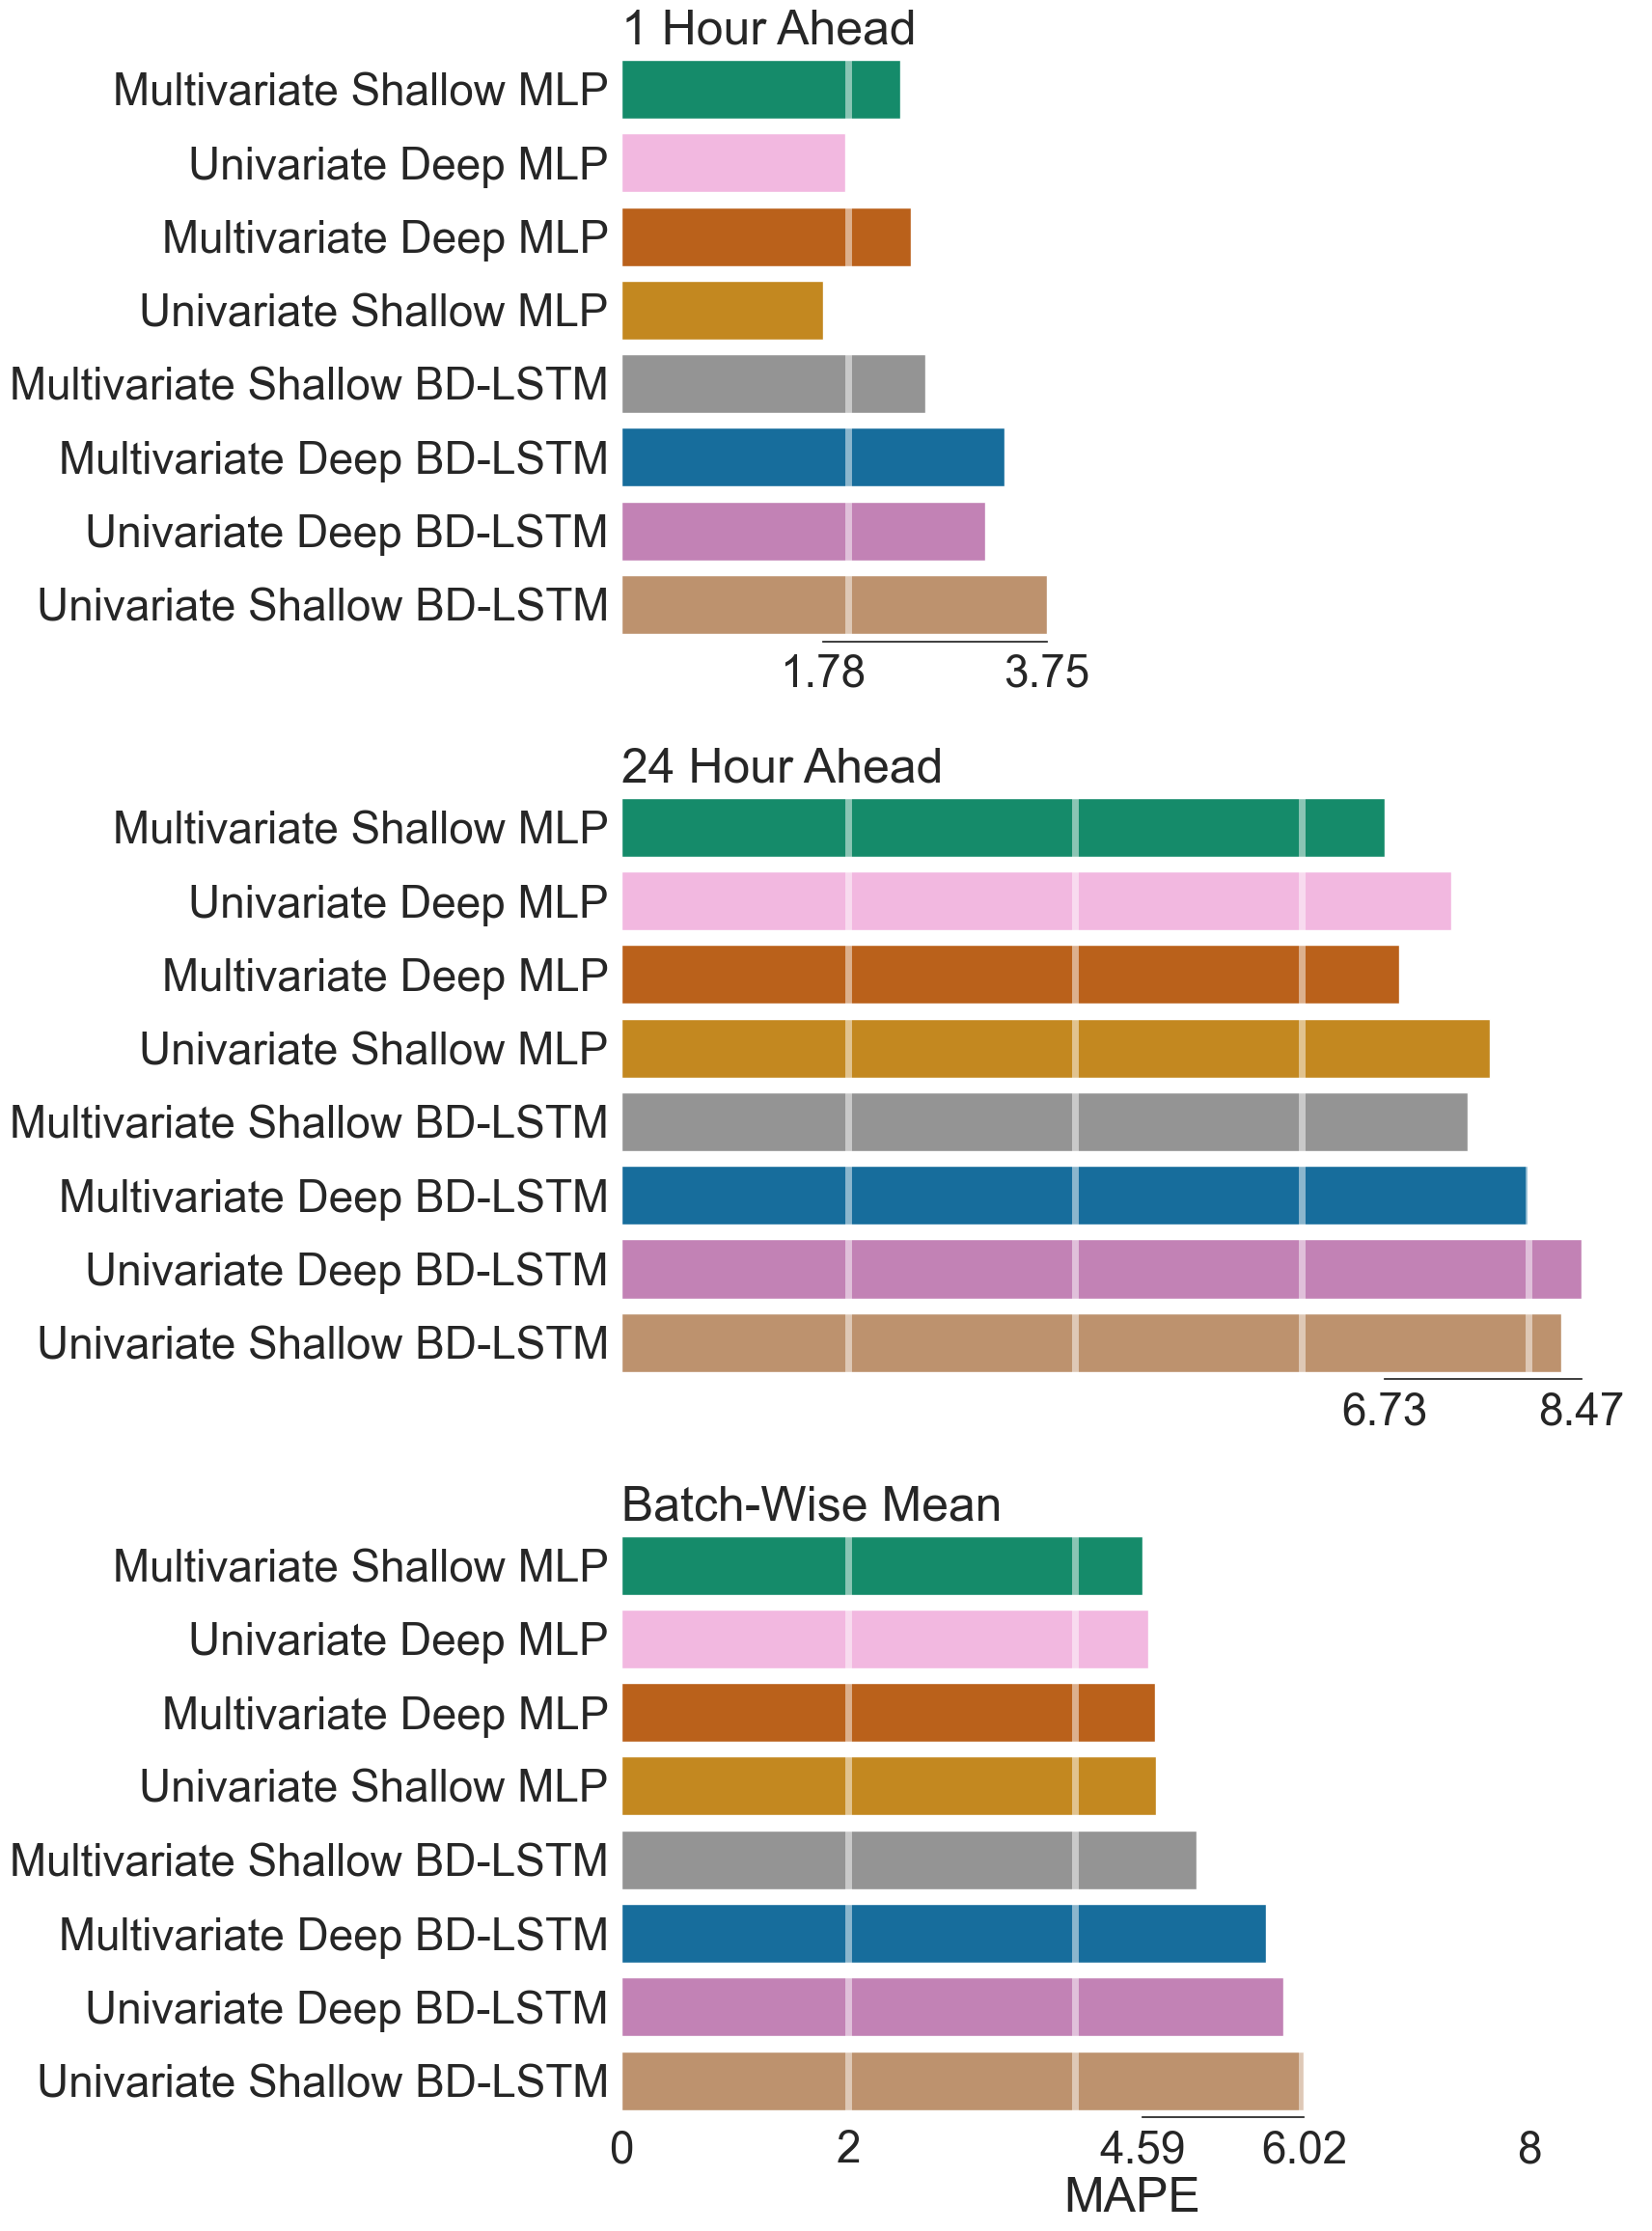

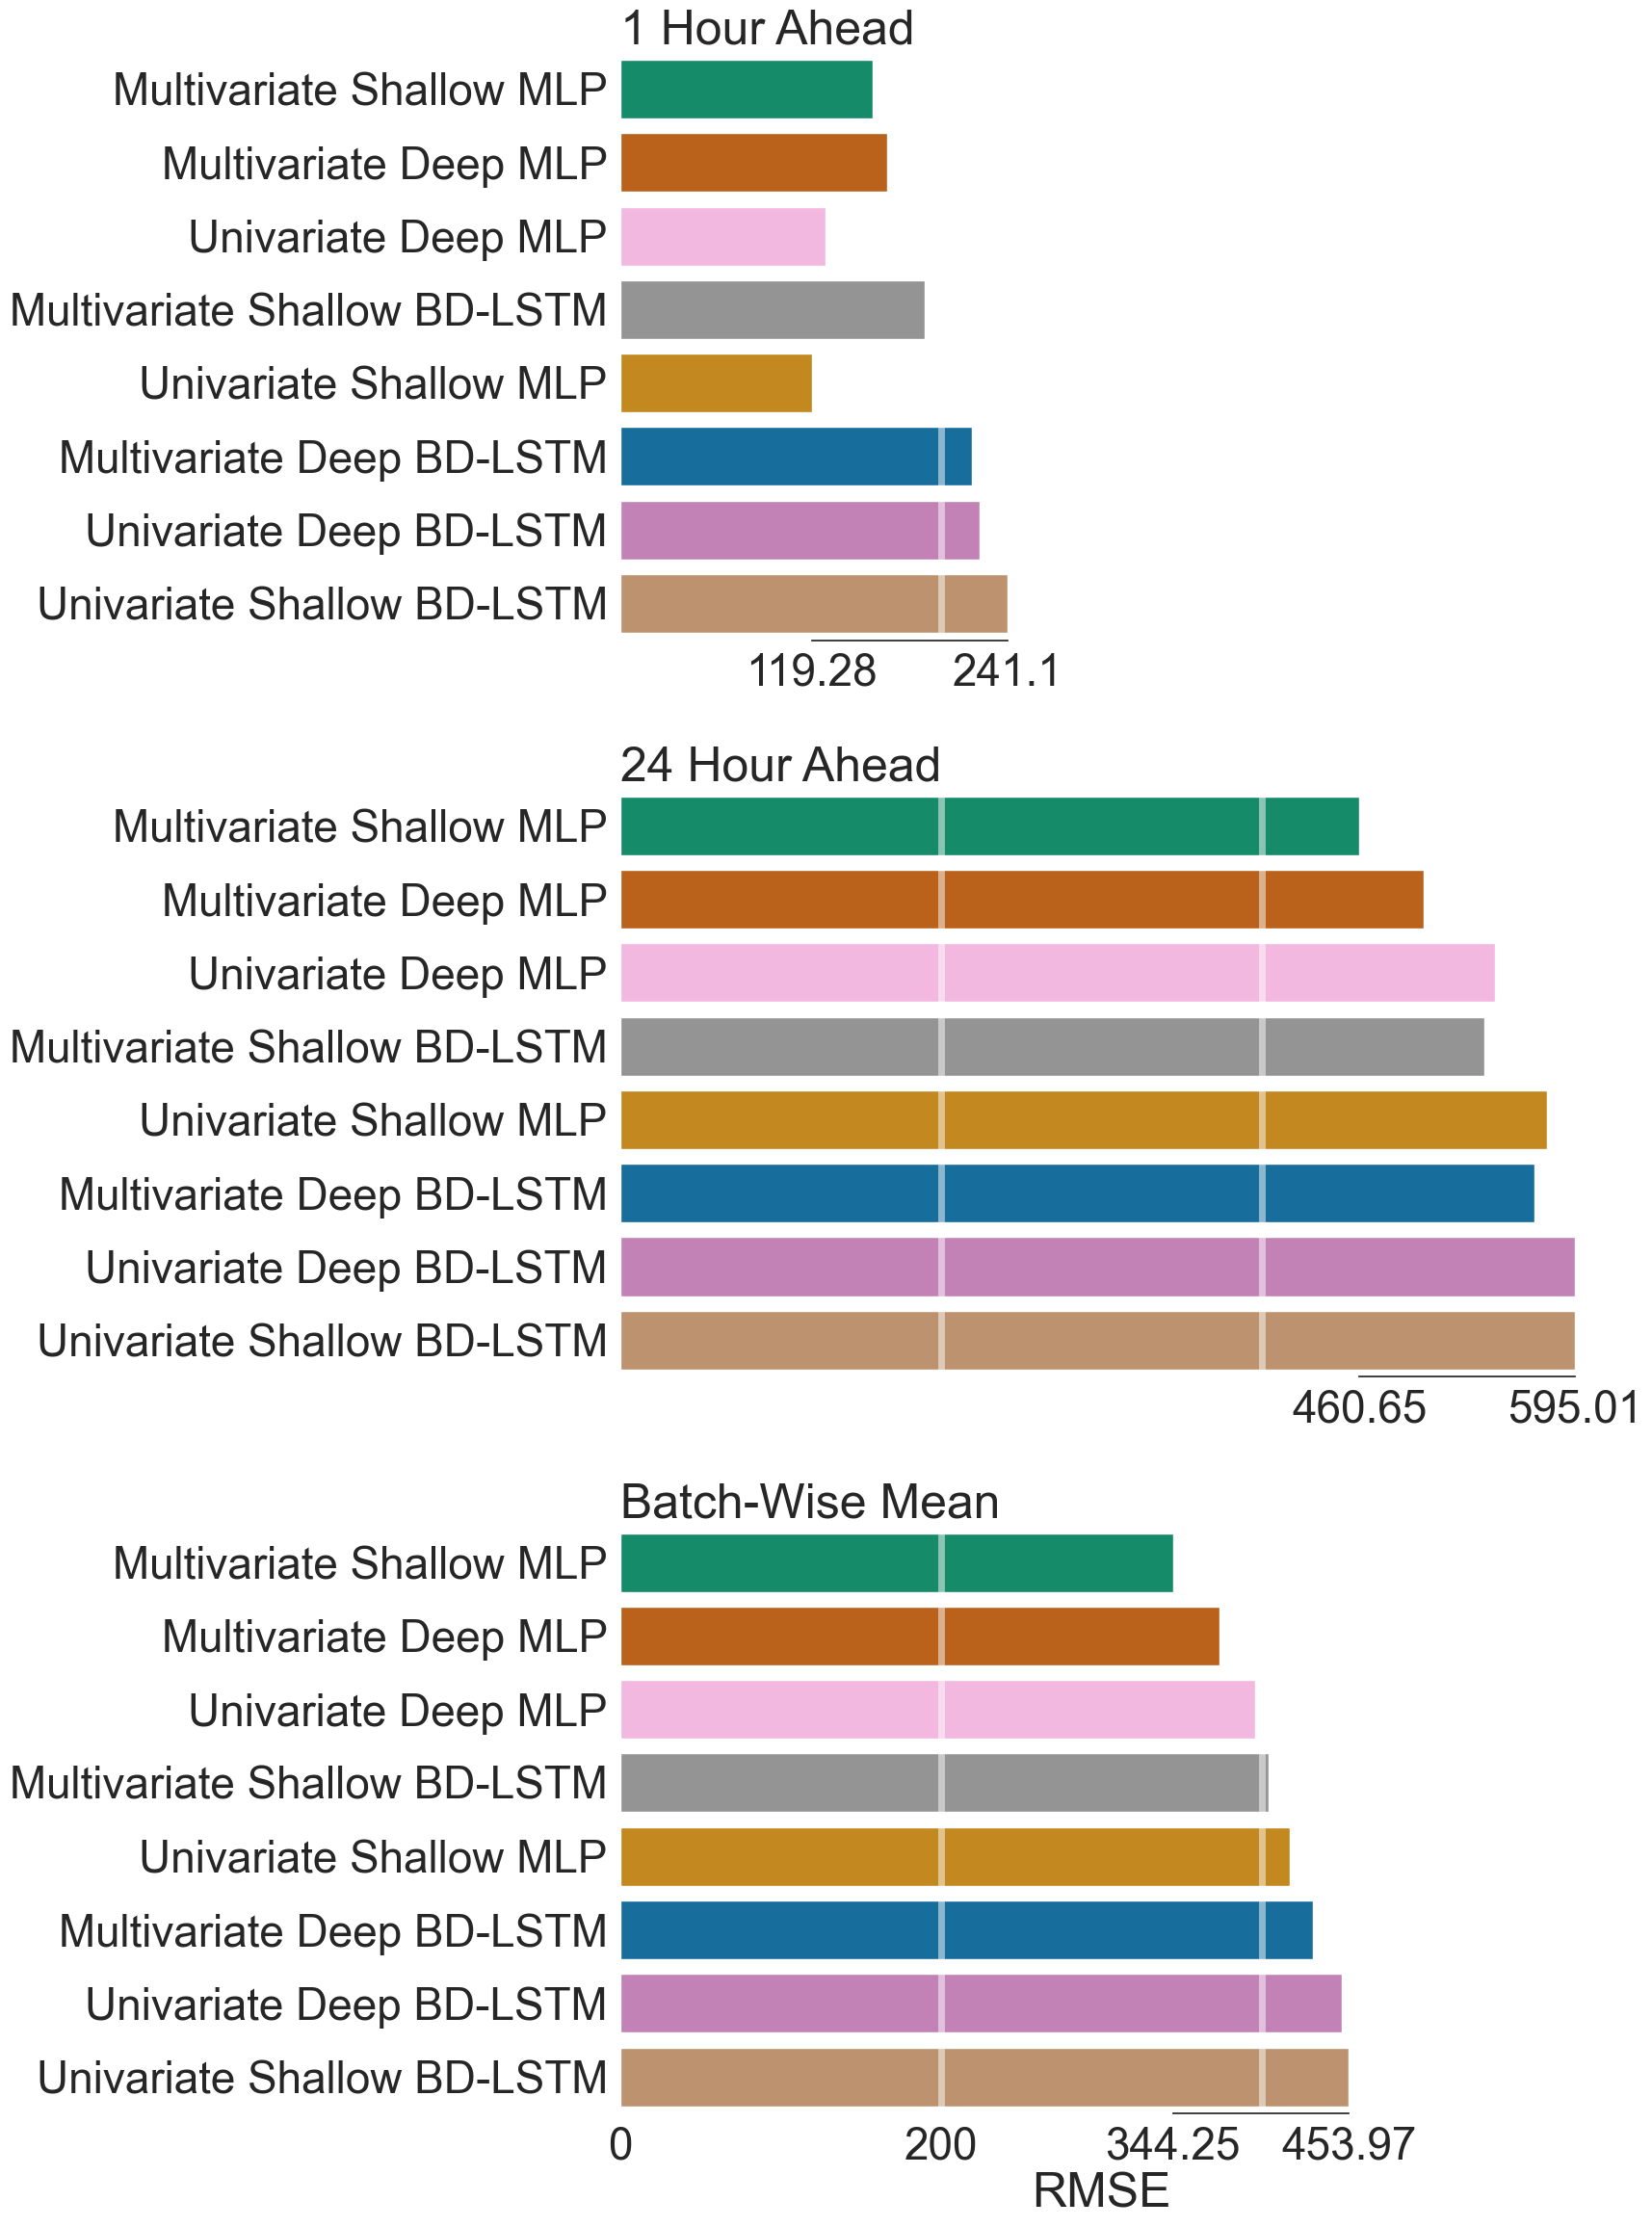

In [133]:
mdl_colour_mapper = mdl_colour_mapper = dict(zip(
    [to_model_label(e) for e in models], palette(len(models))
))

def plot_results(tests, metric):
    '''Take the test result data and a metric. \
Plot the results for each metric and prediction horizon.'''
    n_cols, n_rows = 1, len(horizons)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18*n_cols, 8*n_rows))

    # For each prediction horizon...
    for i, hrz in enumerate(horizons):
        ax = axes[i]
        # Define the column and plot its data.
        metric_col = f"{metric}_{hrz}"
        sns.barplot(
            tests.sort_values(f"{metric}_avg"), x=metric_col, y='model', 
            hue='model', ax=ax, palette=mdl_colour_mapper
        )
    
        ax.tick_params(axis='both', color='white')
        ax.spines['left'].set_visible(False)
    
        ax.set_ylabel('')
        ax.set_title(
            hrz.replace('H' ,' hour ahead')\
                .replace('avg', 'Batch-wise mean').title(), loc='left'
        )

        # Define MAPE plot.
        if metric == 'MAPE':
            x_ticks = [0, 2, 8]
            x_grid = [2, 4, 6, 8]
            ax.set_xlim(0, 9)
        # Define RMSE plot.
        else:
            x_ticks = [0, 200]
            x_grid = [200, 400]
            ax.set_xlim(0, 600)

        # If this isn't the last row of the figure...
        if i+1 < n_rows:
            # Remove x-label and x-ticks.
            ax.set_xlabel('')
            x_ticks = []
        else:
            ax.set_xlabel(metric)
            
        # Neaten the plot in line with Tuftian principles.
        neaten_ticks(
            ax, 'x', [tests[metric_col].min(), tests[metric_col].max()], 
            x_ticks, dp=2
        )

        # Add faint grid lines.
        for line in x_grid:
            ax.axvline(
                line, 0, max(ax.get_xticks()), color='white', 
                alpha=0.5, lw=5
            )
    
    # Further neaten and save the plot.
    show(fig, axes, True, file=f'Test {metric} results')

plot_results(tests, 'MAPE')
plot_results(tests, 'RMSE')
